# Setup/Imports

In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator

from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1,
                            allow_soft_placement=True,
                            device_count={'CPU': 1,
                                          'GPU': 0})
session = tf.Session(config=config)
K.set_session(session)


In [3]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 96
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

# Analysis

In [5]:
# file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'
#file_path='/home/wconlin/run_results_12_2_real/model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_28Jan20-19-43_Scenario-10.h5'
base_path = os.path.expanduser('~/run_results_01_28/')
files = [foo for foo in os.listdir(base_path) if foo.endswith('.h5')]
file_path=base_path+files[6]
file_path = '/home/wconlin/run_results_01_31/model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_01Feb20-14-47_Scenario-.h5'
model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_01Feb20-14-47_Scenario-36.h5
loaded dict: model-conv2d_profiles-dens-temp-itemp-q-rotation_act-target_density-pinj-tinj-curr_target_targ-dens-temp-itemp-q-rotation_profLB-0_actLB-6_ftop-True_01Feb20-14-47_Scenario-36_params.pkl
with parameters: dict_keys(['model_type', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'sample_weighting', 'batch_size', 'process_data', 'predict_deltas', 'epochs', 'loss_function', 'actuator_names', 'scalar_input_names', 'profile_downsample', 'std_activation', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step

In [26]:
scenario.keys()

dict_keys(['model_type', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'sample_weighting', 'batch_size', 'process_data', 'predict_deltas', 'epochs', 'loss_function', 'actuator_names', 'scalar_input_names', 'profile_downsample', 'std_activation', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'nshots', 'excluded_shots', 'lookbacks', 'sig_names', 'dt', 'normalization_dict', 'profile_length', 'mse_weight_vector', 'date', 'runname', 'steps_per_epoch', 'val_steps', 'model_path', 'history', 'history_params'])

In [6]:
full_data_oath = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(test_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [])
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = 'std') #scenario['shuffle_generators'])

Loading
Signals: curr_target, dens, density_estimate, itemp, li_EFIT01, pinj, q, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  461
Number of shots used:  461
Total number of timesteps:  53961
Shots with Complete NaN: 
38330 samples total
Removing ECH
Removed 19151 samples
19179 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 2570 samples
16609 samples remaining
Removing weird I-coils
Removed 4980 samples
11629 samples remaining
Removing NaN
Removed 0 samples
11629 samples remaining
Removing dudtrip
Removed 402 samples
11227 samples remaining
11227 samples remaining after pruning


Normalizing:  61%|######    | 14/23 [00:00<00:00, 133.15it/s]

Total number of samples:  11227
Number of training samples:  11227
Number of validation samples:  0


Normalizing: 100%|##########| 23/23 [00:00<00:00, 130.42it/s]


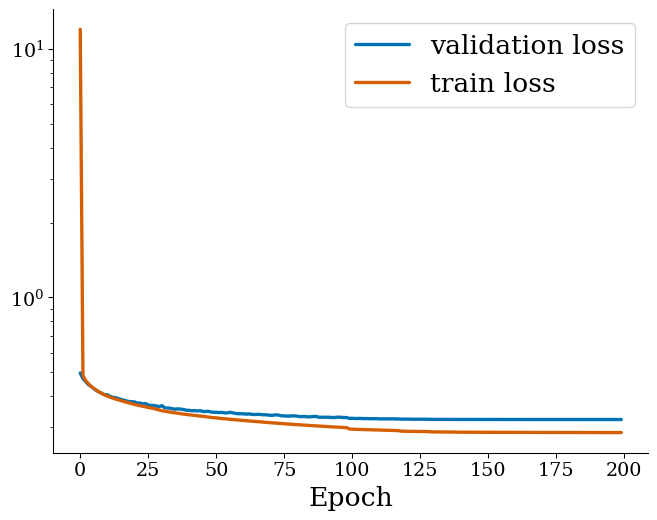

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.semilogy(scenario['history']['val_loss'],label='validation loss')
ax.semilogy(scenario['history']['loss'],label='train loss')
ax.set_xlabel('Epoch', size=20)
ax.legend(fontsize=20)
#plt.ylim(0,.1)
# fig.savefig('training.png')

In [8]:
denormed_traindata=helpers.normalization.denormalize(traindata.copy(),scenario['normalization_dict'])

Denormalizing: 100%|##########| 23/23 [00:00<00:00, 583.59it/s]


In [9]:
def normalize(arr,signal):
    if scenario['predict_deltas']:
        return arr*normalization_dict[signal]['iqr']
    else:
        return helpers.normalization.denormalize_arr(arr,normalization_dict[signal])

In [10]:
profiles=scenario['target_profile_names']
psi = np.linspace(0,1,scenario['profile_length'])

In [11]:
with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_fitters.pkl'),'rb') as f:
    full_pca_fitter = pickle.load(f, encoding='latin1')
with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_kernels.pkl'),'rb') as f:
    kernels = pickle.load(f, encoding='latin1')


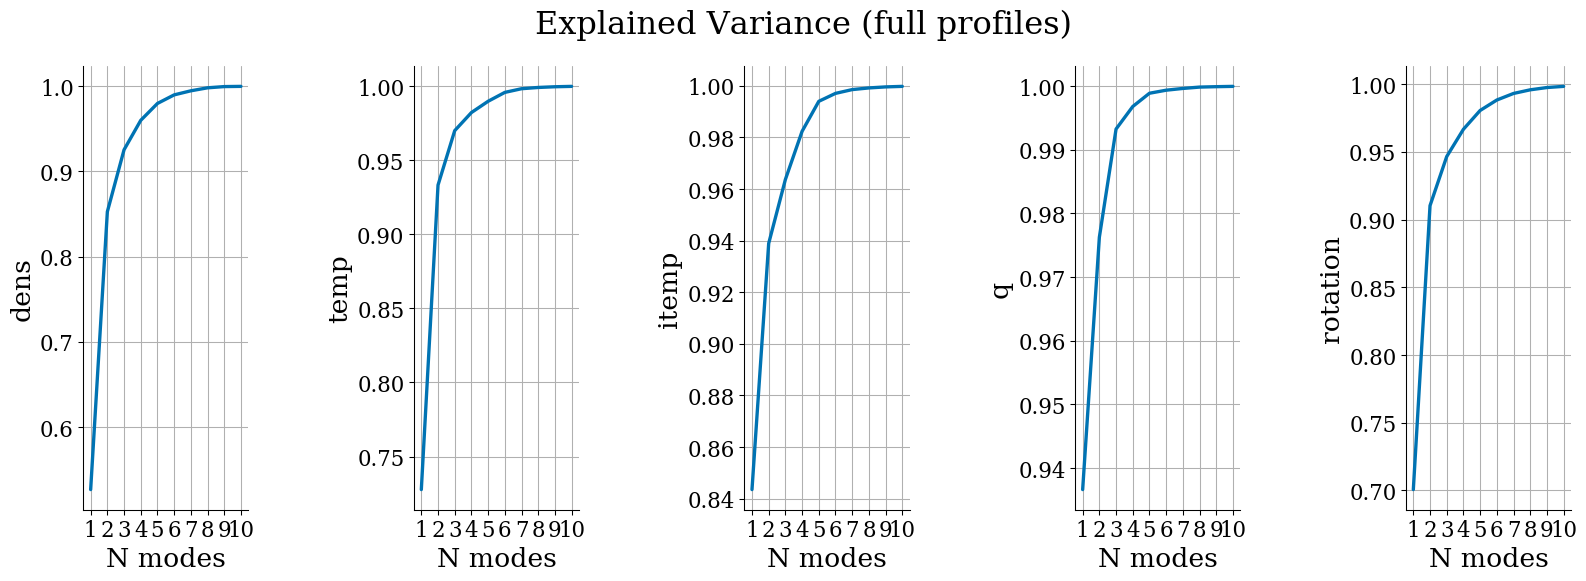

In [12]:
"""plot explained variance"""

ylabels = profiles #['$n_e$','$T_e$','$q$','$\Omega$','$P$']

fig, axes = plt.subplots(1,len(profiles),sharey=False,figsize=(20,6))
for j,profile in enumerate(profiles):
    pca=full_pca_fitter[profile]
    ax = axes[j]
    
    ax.plot(np.arange(1,pca.n_components+1),np.cumsum(pca.explained_variance_ratio_))
    ax.set_ylabel(ylabels[j],size=20)
    ax.set_xlabel('N modes', size=20)
    ax.set_xticks(np.arange(1,pca.n_components+1))
    ax.grid()
    ax.tick_params(axis='both', which='both', labelsize=16)
#     ax.set_yscale('log')

#     ax.set_ylim((10**-3,100))
#     ax.axhline(0,c='k')
fig.suptitle('Explained Variance (full profiles)', size=24)
plt.subplots_adjust(wspace=1.0)
# fig.savefig('explained_variance.png')

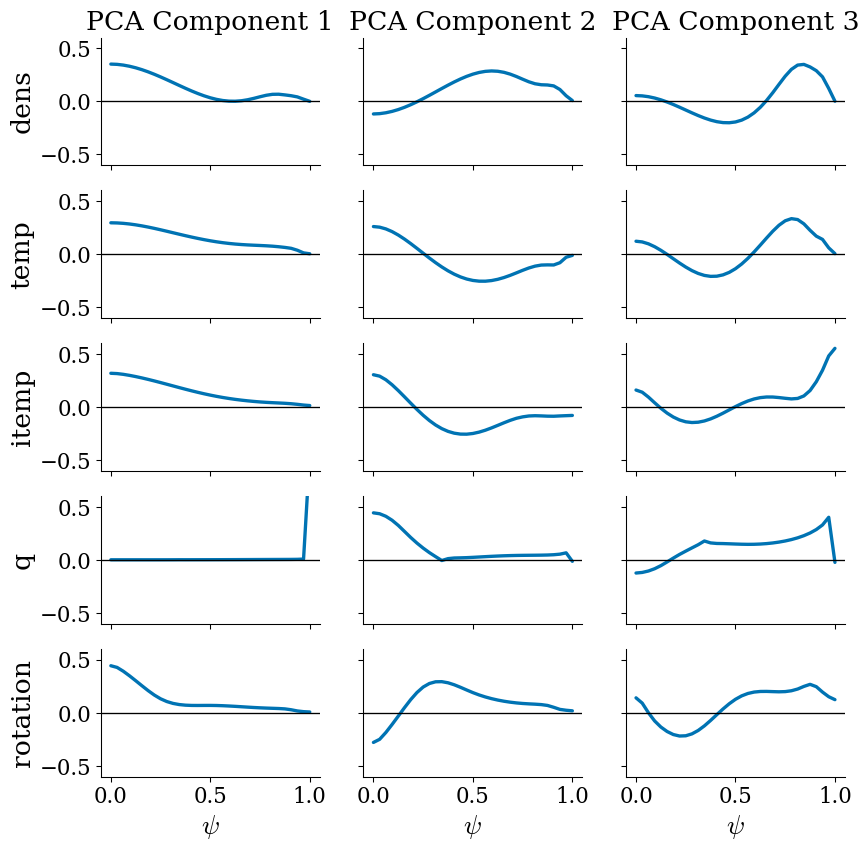

In [13]:
"""plot full pca modes"""

ncols = 5
nrows = 3
ylabels = profiles
fig, axes = plt.subplots(len(profiles),3, sharex=True, sharey=True,figsize=(10,10))
for j,profile in enumerate(profiles):
    pca=full_pca_fitter[profile]
    for i in range(nrows):
        ax= axes[j,i]
        ax.plot(psi,pca.components_[i])
        if i==0:
            ax.set_ylabel(ylabels[j], size=20)
        if j==0:
            ax.set_title('PCA Component {}'.format(i+1), size=20)
        if j==len(profiles)-1:
            ax.set_xlabel('$\psi$',size=20)
        ax.set_ylim(-.6,.6)
        ax.tick_params(axis='both', which='major', labelsize=16)

        ax.axhline(0,c='k',lw=1)
fig.savefig('pca.png')

# Average performance #

In [14]:
import time
begin_time=time.time()

sigs=scenario['actuator_names']
profiles=scenario['target_profile_names']
input_profiles=scenario['input_profile_names']

average_change=np.zeros((len(sigs),len(profiles),len(psi)))
std_change=np.zeros((len(sigs),len(profiles),len(psi)))

denormalized=False
perturbation_size=.1

    
def scalarize_mean(arr, **kwargs):
    return np.mean(arr)

def scalarize_std(arr, **kwargs):
    return np.std(arr)

def scalarize_pca_1(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[2]
    return ret

def scalarize_pca_4(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[3]
    return ret

def scalarize_pca_5(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[4]
    return ret

def scalarize_pca_6(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[5]
    return ret
#for k in range(num_samples):
scalarize_functions=[scalarize_mean,scalarize_std,scalarize_pca_1,scalarize_pca_2, scalarize_pca_3,scalarize_pca_4,scalarize_pca_5,scalarize_pca_6]
scalarize_function_names=['mean','std','pca 1','pca 2', 'pca 3','pca_4','pca_5','pca_6']


num_samples = 1000 

true_profile=np.zeros((len(scalarize_functions),len(profiles),num_samples))
predicted_profile=np.zeros((len(scalarize_functions),len(profiles),num_samples))
true_delta=np.zeros((len(scalarize_functions),len(profiles),num_samples))
predicted_delta=np.zeros((len(scalarize_functions),len(profiles),num_samples))

k=0
while k<num_samples:
    
    index=np.random.choice(len(train_generator))
    #index=k
    sample=train_generator[index]
    inputs=sample[0]
    targets=sample[1]
    
    # only include if mean change in standardized profiles is greater than .1 for at least one profile
    skip=np.zeros(len(profiles))
    for j,profile in enumerate(profiles):
        target=targets['target_{}'.format(profile)][0]
        if abs(np.mean(target))<.1:
            skip[j]=1
    if all(skip):
        continue

    if k%50==0:
        print(k)
        
    predictions=model.predict_on_batch(inputs)

    for j,profile in enumerate(profiles):
        target=targets['target_{}'.format(profile)]
        baseline = inputs['input_{}'.format(profile)][0]
        if denormalized:
            #predicted_profile[i][j][k]=normalize(predicted_profile[i][j][k],profile) 
            #true_profile[i][j][k]=normalize(true_profile[i][j][k],profile)
            predictions[j]=normalize(predictions[j],profile) 
            target=normalize(target,profile)
            baseline=normalize(baseline,profile)

        for i,scalarize in enumerate(scalarize_functions):
            true_delta[i][j][k]=scalarize(target, fitter=full_pca_fitter[profile])
            predicted_delta[i][j][k]=scalarize(predictions[j], fitter=full_pca_fitter[profile])
#             true_profile[i][j][k]=scalarize(target+baseline,fitter=full_pca_fitter[profile])
#             predicted_profile[i][j][k]=scalarize(predictions[j]+baseline,fitter=full_pca_fitter[profile])
            
    k+=1
print(time.time()-begin_time)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
19.0896635055542


In [15]:
def find_bounds(true,pred):
    arr = np.concatenate([true,pred]).flatten()
    med = np.median(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    iqr =  np.percentile(arr, 75) - np.percentile(arr, 25)
    bounds=(med-3*iqr,med+3*iqr)
    bounds=(mean-3*std,mean+3*std)
    return bounds

/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:4840: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == 'log':


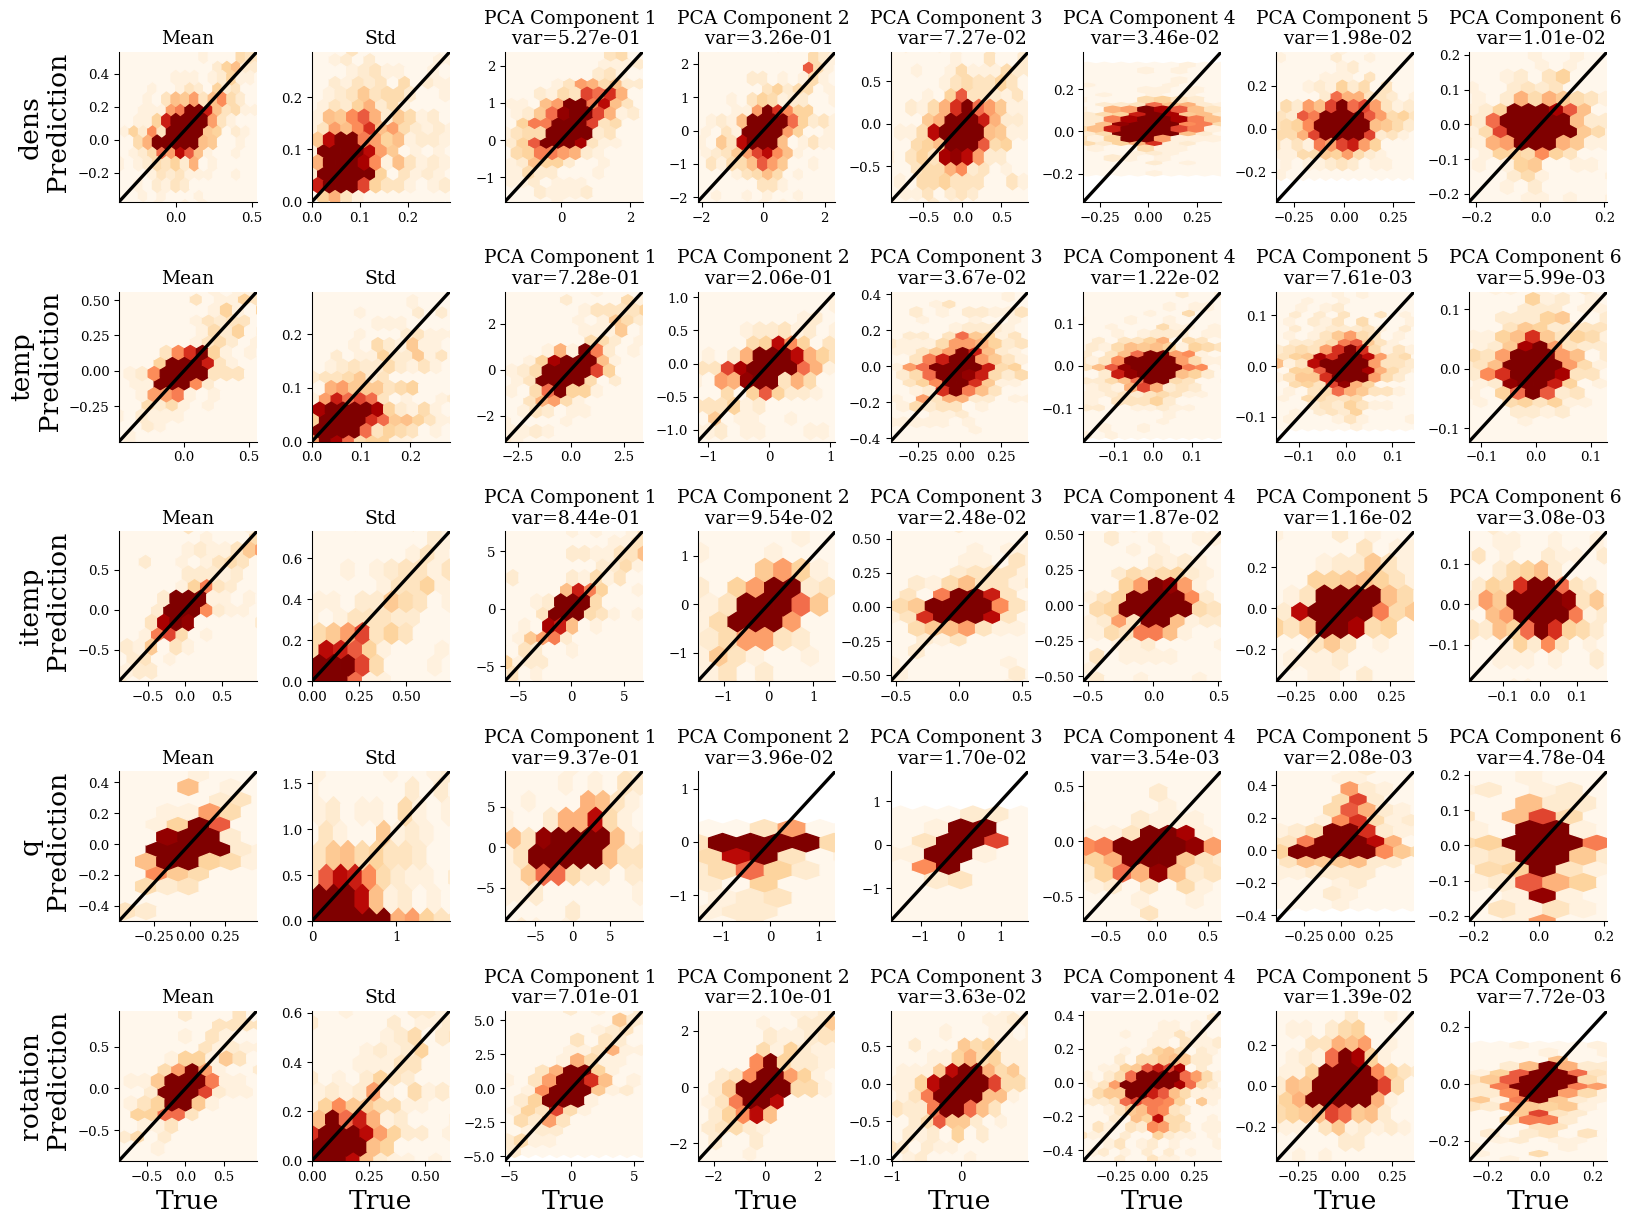

In [16]:
"""Scatter plot of deltas"""

fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), figsize=(20,15))
ylabels = profiles #['$\Delta n_e$','$\Delta T_e$','$\Delta q$','$\Delta \Omega$','$\Delta P$']

for i,profile in enumerate(profiles):
    for j,scalarize_name in enumerate(scalarize_function_names):
#         if j==0:
#             continue
        pred=predicted_delta[j][i]
        true=true_delta[j][i]
      
        ax = axes[i,j]
        if j==0:
            ax.set_title('Mean',size=14)
        if j==1:
            ax.set_title('Std',size=14)
        if j>1:
            ax.set_title('PCA Component {} \n var={:.2e}'.format(j-1,full_pca_fitter[profile].explained_variance_ratio_[j-2]),size=14)
        
        # 1-1 plot:
#         ax.scatter(true_profile[j][i],predicted_profile[j][i],alpha=0.1)
        ax.hexbin(true,pred,gridsize=20,bins=np.arange(20),mincnt=0, cmap='OrRd')
        if j != 1:
            ax.set_xlim(find_bounds(true,pred))
            ax.set_ylim(find_bounds(true,pred))
        else:
            ax.set_xlim(0,find_bounds(true,pred)[1])
            ax.set_ylim(0,find_bounds(true,pred)[1])
        # for raw
        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color='k')
        if i==len(profiles)-1:
            ax.set_xlabel('True',size=20)
        if j==0:
            ax.set_ylabel(ylabels[i] +  '\n Prediction', size=20)
        ax.tick_params(axis='both', which='major', labelsize=10)


plt.subplots_adjust(hspace=.6,wspace=.4)
# fig.savefig('pca_acc.png')

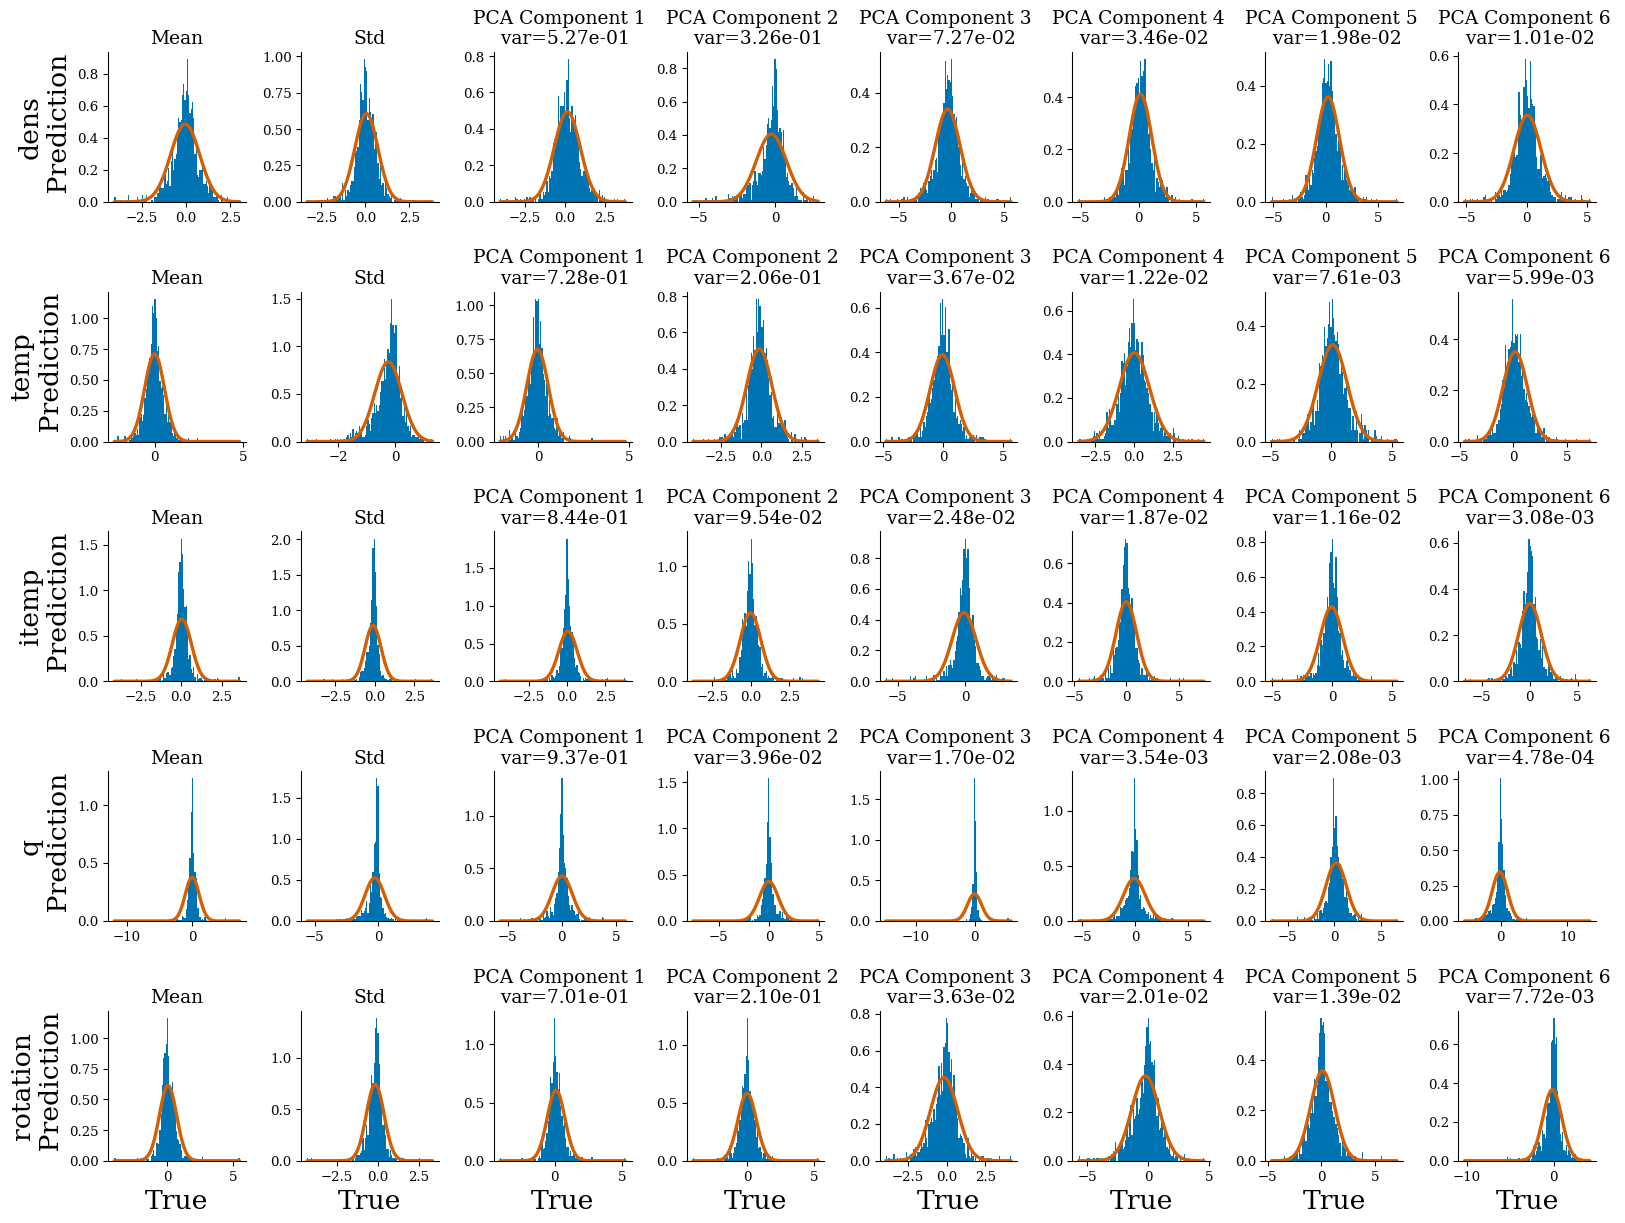

In [17]:
"""hist plot of deltas"""
from scipy.stats import norm

fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), figsize=(20,15))
ylabels = profiles #['$\Delta n_e$','$\Delta T_e$','$\Delta q$','$\Delta \Omega$','$\Delta P$']

for i,profile in enumerate(profiles):
    for j,scalarize_name in enumerate(scalarize_function_names):

        pred=predicted_delta[j][i]
        true=true_delta[j][i]
      
        ax = axes[i,j]
        if j==0:
            ax.set_title('Mean',size=14)
        if j==1:
            ax.set_title('Std',size=14)
        if j>1:
            ax.set_title('PCA Component {} \n var={:.2e}'.format(j-1,full_pca_fitter[profile].explained_variance_ratio_[j-2]),size=14)
        

        arr = pred-true
        arr = arr/np.sqrt(np.mean(true**2))
        ax.hist(arr, bins=100, density=True)
        mean = np.mean(arr)
        variance = np.var(arr)
        sigma = np.sqrt(variance)
        x = np.linspace(min(arr), max(arr), 100)
        ax.plot(x, norm.pdf(x, mean, sigma))

        if i==len(profiles)-1:
            ax.set_xlabel('True',size=20)
        if j==0:
            ax.set_ylabel(ylabels[i] +  '\n Prediction', size=20)
        ax.tick_params(axis='both', which='major', labelsize=10)


plt.subplots_adjust(hspace=.6,wspace=.4)

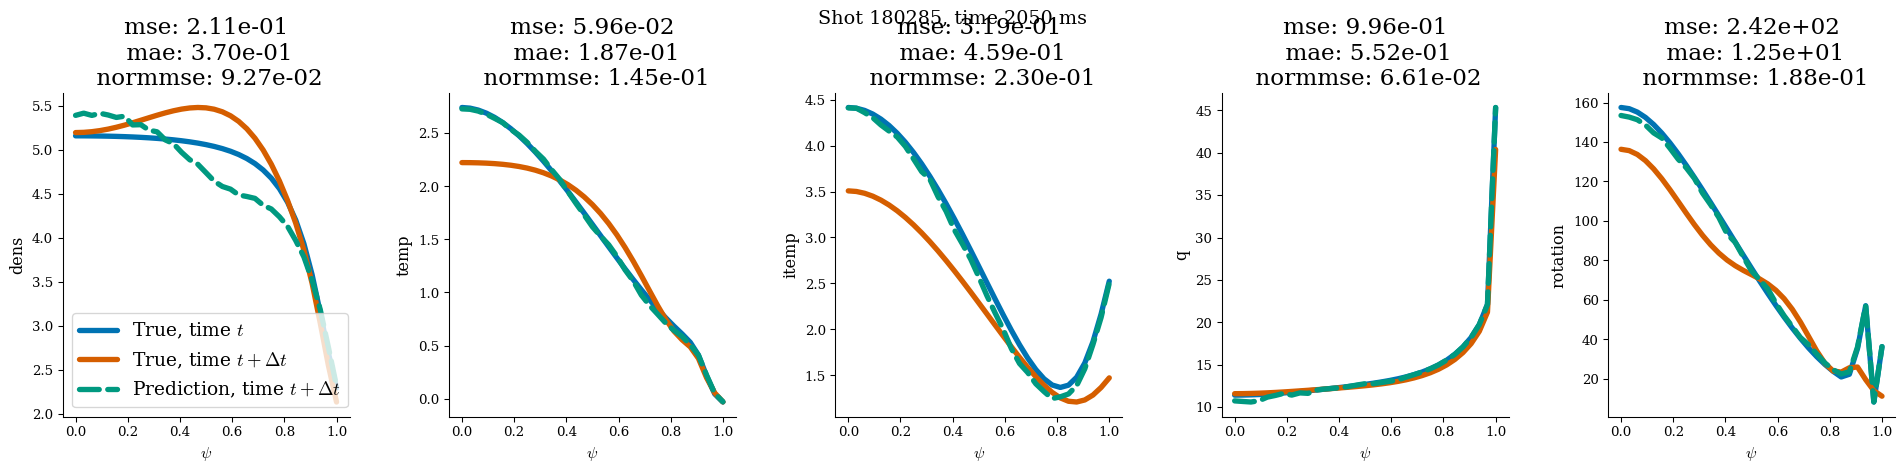

In [30]:


index = 94117
index = 1
index = np.random.randint(len(train_generator))
inputs, targets,_ = train_generator[index]
# inputs,targets,_ = train_generator.get_data_by_shot_time([163303],[12])
# inputs = inputs[index]
# targets = targets[index]

shotnum = train_generator.cur_shotnum[0,0]
shottime = train_generator.cur_times[0,-scenario['lookahead']-1]

predictions=model.predict_on_batch(inputs)
ylabels = profiles #['$n_e$','$T_e$ (keV)','$q$','$\Omega$','$P$ (kPa)']

fig, axes = plt.subplots(1,len(profiles),sharex=False, figsize=(20,5))
for j, profile in enumerate(profiles):
    ax = axes[j]
    inp = inputs['input_{}'.format(profile)].squeeze()
    true = inputs['input_{}'.format(profile)].squeeze() + targets['target_{}'.format(profile)].squeeze()
    pred = inputs['input_{}'.format(profile)].squeeze() + predictions[j].squeeze()

    inp = helpers.normalization.denormalize_arr(inp,normalization_dict[profile])
    true = helpers.normalization.denormalize_arr(true,normalization_dict[profile])
    pred = helpers.normalization.denormalize_arr(pred,normalization_dict[profile])

    ax.plot(psi,inp,lw=4,label='True, time $t$')
    ax.plot(psi,true,lw=4,label='True, time $t+\Delta t$')
    ax.plot(psi,pred,lw=4,ls='--',label='Prediction, time $t+\Delta t$')
    ax.set_ylabel(ylabels[j],size=12)
    title = ''
    title += 'mse: {:.2e}'.format(mse(true,pred))
    title += '\n mae: {:.2e}'.format(mae(true,pred))
    title += '\n normmse: {:.2e}'.format(normed_mse(true,pred))
    ax.set_title(title)
    ax.set_xlabel('$\psi$',size=12)
    if j==0:
        ax.legend(fontsize=14)
    fig.suptitle("Shot {}, time {} ms".format(int(shotnum), int(shottime)))
    ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
# fig.savefig('prof_pred_ex.png')

In [19]:
def mse(true,pred):
    return np.mean((pred-true)**2)

def mae(true,pred):
    return np.mean(np.abs(true-pred))

def normed_mse(true,pred):
    num = np.mean((pred-true)**2)
    den = (np.mean((true)**2))
    return np.sqrt(num/den)

'mae'

# Metaparameters

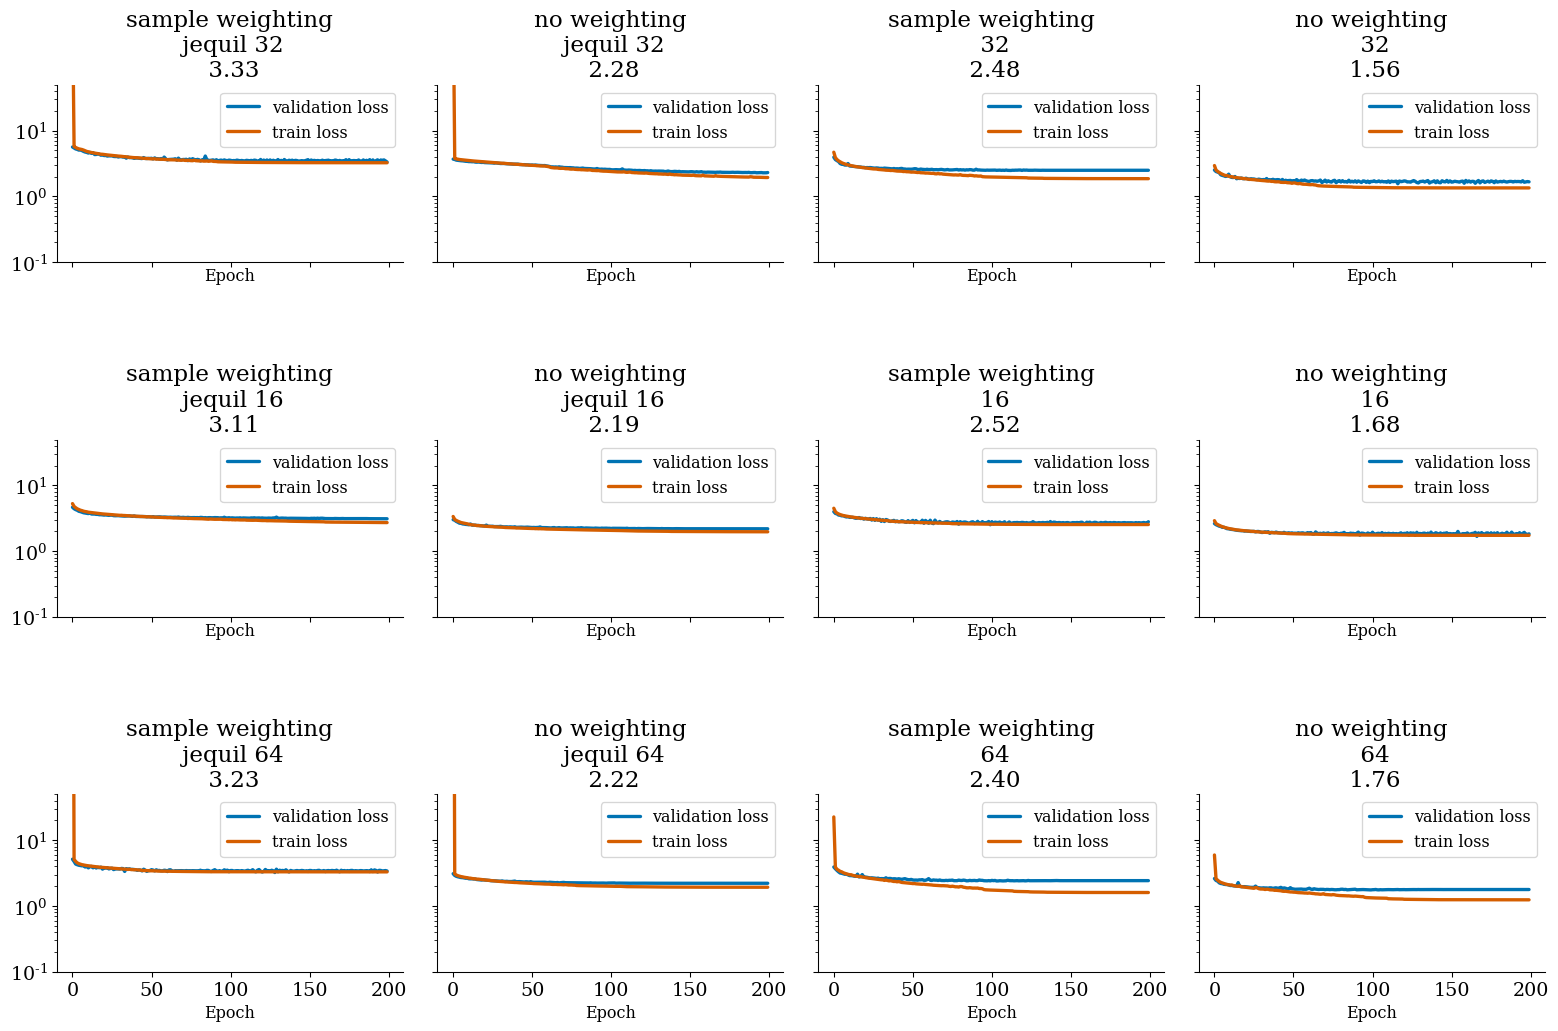

In [238]:
base_path = os.path.expanduser('~/run_results_01_28/')
files = [foo for foo in os.listdir(base_path) if foo.endswith('.pkl')]
files = sorted(files, key = lambda x: int(x.split('-')[-1].split('_')[0]))

fig, ax = plt.subplots(3,len(files)//3, sharex=True,sharey=True, figsize=(20,12))
ax = ax.flatten()
for i, file in enumerate(files):
    file_path=base_path+file

    with open(file_path, 'rb') as f:
        scenario = pickle.load(f, encoding='latin1')
    ax[i].semilogy(scenario['history']['val_loss'],label='validation loss')
    ax[i].semilogy(scenario['history']['loss'],label='train loss')
    ax[i].set_xlabel('Epoch', size=12)
    ax[i].legend(fontsize=12)
    ax[i].set_ylim((.1,50))
    title = ''
    if scenario['sample_weighting']:
        title += 'sample weighting'
    else:
        title += 'no weighting'
    if 'jequil' in scenario['sig_names']:
        title += '\n jequil ' + str(scenario['model_kwargs']['max_channels'])
    else:
        title += '\n ' + str(scenario['model_kwargs']['max_channels'])
    title += '\n {:.2f}'.format(np.min(scenario['history']['val_loss']))
    ax[i].set_title(title)
plt.subplots_adjust(hspace=1,wspace=.1)


In [240]:
sorted(scenario['history'].keys())

['loss',
 'lr',
 'target_dens_denorm_MAE',
 'target_dens_loss',
 'target_dens_perBLMAE',
 'target_dens_sgn_acc',
 'target_itemp_denorm_MAE',
 'target_itemp_loss',
 'target_itemp_perBLMAE',
 'target_itemp_sgn_acc',
 'target_q_denorm_MAE',
 'target_q_loss',
 'target_q_perBLMAE',
 'target_q_sgn_acc',
 'target_rotation_denorm_MAE',
 'target_rotation_loss',
 'target_rotation_perBLMAE',
 'target_rotation_sgn_acc',
 'target_temp_denorm_MAE',
 'target_temp_loss',
 'target_temp_perBLMAE',
 'target_temp_sgn_acc',
 'val_loss',
 'val_target_dens_denorm_MAE',
 'val_target_dens_loss',
 'val_target_dens_perBLMAE',
 'val_target_dens_sgn_acc',
 'val_target_itemp_denorm_MAE',
 'val_target_itemp_loss',
 'val_target_itemp_perBLMAE',
 'val_target_itemp_sgn_acc',
 'val_target_q_denorm_MAE',
 'val_target_q_loss',
 'val_target_q_perBLMAE',
 'val_target_q_sgn_acc',
 'val_target_rotation_denorm_MAE',
 'val_target_rotation_loss',
 'val_target_rotation_perBLMAE',
 'val_target_rotation_sgn_acc',
 'val_target_temp_

In [ ]:
base_path = os.path.expanduser('~/run_results_01_30/')
files = [foo for foo in os.listdir(base_path) if foo.endswith('.pkl')]
files = sorted(files, key = lambda x: int(x.split('-')[-1].split('_')[0]))

fig, ax = plt.subplots(3,len(files)//3, sharex=True,sharey=True, figsize=(20,12))
ax = ax.flatten()
for i, file in enumerate(files):
    file_path=base_path+file

    with open(file_path, 'rb') as f:
        scenario = pickle.load(f, encoding='latin1')
    loss = np.zeros(scenario['epochs'])
    val_loss = np.zeros(scenario['epochs'])
    for key,value in scenario['history'].items():
        if 'mean_squared_error' in key:
            if 'val' in key:
                val_loss += value
            else:
                loss += value
                
    ax[i].semilogy(val_loss,label='validation loss')
    ax[i].semilogy(loss,label='train loss')
    ax[i].set_xlabel('Epoch', size=12)
    ax[i].legend(fontsize=12)
    ax[i].set_ylim((.1,50))
    title = ''
    if scenario['sample_weighting']:
        title += 'sample weighting'
    else:
        title += 'no weighting'
    title += '\n channels: ' + str(scenario['model_kwargs']['max_channels'])
    title += '\n mse weight:' + str(scenario['mse_weight_edge'])
    title += '\n min val loss{:.2f}'.format(np.min(val_loss))
    ax[i].set_title(title)
plt.subplots_adjust(hspace=1,wspace=.1)
